# Loco learning MNIST

A simple example on how to train MNIST digits, step by step

## About the MNIST dataset

The postal service of the United States provided this dataset years ago. It consists on thousends of 28x28 pixels images repressenting a handwritten digit, they are correctly labeled (from 0 to 9). 

![title](pictures/mnistSample.jpeg)

The images are grayscale, so each pixel is represented by a value that goes from 0 to 255.

Because it is a well known dataset, it is perfect to be used as a first project for machine learning.

## Define the problem

Given a set of correctly labeled data, we will build a simple algorithm which will be able to label new data. This means that we will, by the end of this demo, be able to provide a NEW image with a handwritten digit and the system should be able to determine which digit it is.



In [1]:
# first, lets load the basics
from IPython.display import display, Image # Some jupyter notebook libs to show images
import matplotlib.pyplot as plt            # A python lib to show images
import matplotlib.image as mpimg           # More for images
import pandas as pd                        # THE library to read csv files
import tensorflow as tf                    # Google's machine learning library
import numpy as np                         # Calculus library, very good to work with matrices
import requests                            # A simple HTTP client library
import sys                                 # Utilities to access the shell
import os.path                             # File and dirs utilities
from tqdm import tqdm, tqdm_notebook       # A fancy progress bar tool
from scipy.ndimage import imread           # To read images from disk
import cv2                                 # To handle images 

## Getting the data

There are a number of formats out there, and typically you should read the images directly and convert them into a matrix, but in order to save time and be focus on the problem we will download a CSV version directly.

The format is the following.

**Each image is 28x28 pixels, those are reshaped into a single dimensions of 28*28 = 784 values.** Also we need to know which digits corresponds to each image, so before those 784 values we add a number (from 0 to 9) that tells use which one is the digit on the image. That gives us 784 + 1 = 785 columns, where the first element is the digit itself.

We will define a simple ```download_file``` function to do the downloading for us.

In [2]:
def download_file(link, file_name):
    if os.path.isfile(file_name):
        print("File was already there")
    else:
        
        print ("Downloading %s" % file_name)
        r = requests.get(link, stream=True)
        
        # Total size in bytes.
        total_size = int(r.headers.get('content-length', 0)); 
        print("Size in KB %.2f" % (total_size/1024))
        with open(file_name, 'wb') as f:
            for data in tqdm_notebook(r.iter_content(1024), total=int(total_size/1024), unit="KB"):
                f.write(data)
            
    return file_name

### Download the info

In [3]:
mnist_filename = "train.csv"
download_file("https://raw.githubusercontent.com/sbussmann/kaggle-mnist/master/Data/train.csv", mnist_filename)

Size in KB 9108.27


'train.csv'

### Data format

It is important now to understand the format of the files

From http://makeyourownneuralnetwork.blogspot.com.au/2015/03/the-mnist-dataset-of-handwitten-digits.html


* The first value is the "label", that is, the actual digit that the handwriting is supposed to represent, such as a "7" or a "9". It is the answer to which the neural network is aspiring to classify.

* The subsequent values, all comma separated, are the pixel values of the handwritten digit. The size of the pixel array is 28 by 28, so there are 784 values after the label.

**So the first thing we need to do is separate the actual labels from the data itself**, we will call the data X and the labels y, as we have a train and a test set, we will call them X_train, X_test, y_train, y_test







In [4]:
mnist = pd.read_csv(mnist_filename).as_matrix() # We need to call as_matrix so we can use numpy arrays

### Quick data exploration

Lets see what we have in our mnist variable

In [5]:
print("Shape ", mnist.shape)
print("Total rows ", mnist.shape[0])
print("Total columns", mnist.shape[1])

Shape  (42000, 785)
Total rows  42000
Total columns 785


### Now, lets separate the data from the labels

In numpy this is pretty easy, when operating with a matrix (lets call it MATRIX), one has to provide which rows and columns are to be used. One can simply access row 5 and column 20 by doing MATRIX[5, 20]. 

In our case we want the first column and ALL the rows, that is done by effectively selecting all the rows with 
```
:
``` 
so 

```
train[:,0]
```

For the data itself we want ALL the rows and all the columns except the first one, as everything is zero-indexed, we want everything from the column number one, that is done by using

```
1:
```

so

```
train[:, 1:]
```

#### Finally note that in machine learning it is common to refer as the data as "X" and the labels as "y"

In [6]:
train_split = int(mnist.shape[0] * 0.8)   # 80% of he data goes to training set, 20% to test set

X = mnist[:, 1:]  # All rows, columns from 1 to the end
y = mnist[:, 0]    # All rows, just column 0

X_train = X[0:train_split, ]
y_train = y[0:train_split, ]

X_test = X[train_split:, ]
y_test = y[train_split:, ]


Now lets make sure that our shapes are correct, the data should be in shape Nx786 where N is the number of rows, in the case of y, the shape should be N, where N again is the number of rows

In [7]:
print("Shape of X_train ", X_train.shape, " y_train ", y_train.shape)
print("Shape of X_test ", X_test.shape, " y_test ", y_test.shape)

Shape of X_train  (33600, 784)  y_train  (33600,)
Shape of X_test  (8400, 784)  y_test  (8400,)


Lets do a simple explorarion of the dataset, lets grab the first element

In [8]:
sample = X_train[42,]
sample_label = y_train[42]

In [9]:
print(sample)
print("Which corresponds to digit ", sample_label)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0 231  11   0   0   0   0   0   0   0   0   0 202  92
   0   0   0   0   0   0   0   0   0   0   0   0   0   0  60 244 116   0
   0   0   0   0   0   0   0   0 253  92   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 176 252 116   0   0   0   0   0   0   0   0  85
 253  92   0   0   0   0   0   0   0   0   0   0   0   0   0  26 224 252
  74   0   0   0   0   0   0   0   0 210 253  92   

Remember that the values are the pixels, and they are represented in a vector of 28x28 = 784 pixels, lets reshape this sample to its original form so we can display the image.



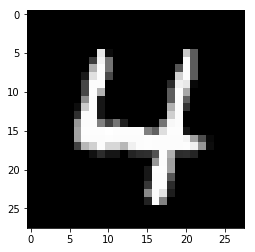

Label is 4


In [10]:
sample_image = sample.reshape((28,28))
plt.imshow(sample_image, cmap='gray')
plt.show()
print("Label is", sample_label)

Now, as we are dealing with 

In [11]:
print("Min value is ", np.min(X_train))
print("Max value is ", np.max(X_train))

Min value is  0
Max value is  255


No surprises here, as we are dealing with grayscale images, values range from 0 to 255.


## Normalization

neural networks like values around zero due to numerical stability reasons. We are going to convert them using max-min scaling

The formula to use is

![title](pictures/normalization.png)


In [12]:
max_value = np.max(X_train)
min_value = np.min(X_train)

X_train_normalized = (X_train - min_value) / (max_value - min_value)
X_test_normalized = (X_test - min_value) / (max_value - min_value)

And lets verify some random values to make triple sure everything is fine

In [13]:
X_train_normalized[42,]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

### Next, we need to prepare our labels (y values)

We are going to ```one hot encode``` the y values, so...

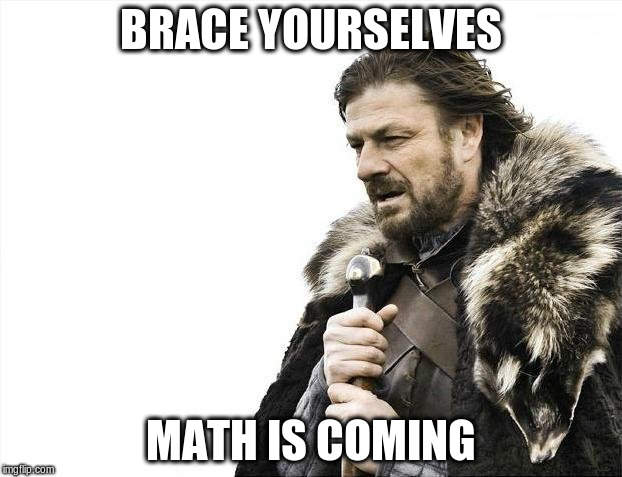

In [14]:
img = Image(filename='pictures/braceYourselves01.jpeg')
img

### One-hot-encode

Because we are trying to predict are 10 different possible digits, we need an effective way to 

* Assign predictions to the correct digit
* Measure our error in case the prediction is wrong

That is achieved using something called cross entropy, and in order to have cross entropy, we need to first one-hot-encode our values.

One-hot-encoding is a simple technique, to ilustrate it, lets have a look at our first 5 ```y``` values

In [15]:
print("First 5 labels ", y_train[0:5])

First 5 labels  [1 0 1 4 0]


So first labels correspond to digits 1, 0, 1, 4 and 0. At the moment our ```y_train``` variable is a vector (or a list), one-hot-encoding means transforming that into a matrix of as many columns as digits we have (that is, 10 columns).

Image that we have a value being 4, we will transform that into a list of 10 elements, where all the elements exect the one at position 4 are zero, example

``` 
4 becomes => [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] 
```

Once we have our one-hot-encoded values, we will go from our initial vector of correct labels to a matrix.

And then we will apply this formula

![title](pictures/crossEntropy.png)


### Do not worry if you do not get the math inmediatly (I did not either, at first)

The important part to remember is that the predicted probabilities will be a list of 10 positions, and if you sum all of them, you get 1. Of course the prediction is the one with the highest value

In [16]:
y_train_one_hot = np.eye(10)[y_train.reshape(-1)]
y_test_one_hot = np.eye(10)[y_test.reshape(-1)]

print("Remember, the first elements where",  y_train[0:5])

Remember, the first elements where [1 0 1 4 0]


In [17]:
print("New shape for labels (train set) ", y_train_one_hot.shape)
y_train_one_hot[0:5]

New shape for labels (train set)  (33600, 10)


array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## How to make predictions

Ultimately, in order to get a prediction we just need to execute the following formula

![title](pictures/prediction.png)


### Again, do not let the math intimidate you. 

A sum is normally translated into code as a simple loop, however, here we are operating with matrices (remember, both X and y are now matrices), matrix multiplications are EXPENSIVE operations. The naive implementation of a matrix multiplication has a cost of

## $O(n)^3$

Fortunately there are other methods such as the Strassen algorithm that can run in

## $O(n)^{2.8074}$

Even with small N, the difference is huge, for example assume N=100

## $100^3 = 1000000 $

## $100^{2.8074} = 411907.78 $

Fortunately for us, numpy (and tensorflow) already implement efficient matrix multiplications algorithms.

## What is our N?

Well, we are going to use our X_train_normalized for that, so, lets see

In [18]:
print(X_train_normalized.shape[0])

33600


### Our N is fairly big!

So instead of feeding our algorithm all the training examples at once, we will feed it batches instead (the batch size is configurable)

### Prepare code to provide batches of data

In [19]:
def next_batch(X, y, batchSize):
    # loop over our dataset `X` in mini-batches of size `batchSize`
    for i in np.arange(0, X.shape[0], batchSize):
        # yield a tuple of the current batched data and labels
        yield (X[i:i + batchSize], y[i:i + batchSize])
    

Now lets start playing with the interesting stuff. 

Initially a simple logistic regression is going to be done using tensorflow.

In [20]:
epochs_logistic_regression = 15 # How many passes on all the data
batch_size = 256 # We will pass 256 examples each time
total_batches = X_train_normalized.shape[0] // batch_size # How many batches we will use
columns = 784 # Remember, we are dealing with images of 28x28 pixels unrolled as 28*28 = 786
labels = 10 # There are 10 possible labels (as we have 10 digits from 0 to 9)

weights = tf.Variable(tf.truncated_normal(shape=(columns, labels), stddev=0.1))
biases = tf.Variable(tf.zeros(labels))

X = tf.placeholder(tf.float32, shape=(None, columns), name="X")
y = tf.placeholder(tf.float32, shape=(None, labels), name="y")

logits_logistic_regression = tf.add(tf.matmul(X, weights), biases)
predictions_logistic_regression = tf.nn.softmax(logits_logistic_regression)
softmax_calc = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits_logistic_regression)
cost = tf.reduce_mean(softmax_calc)

train_step = tf.train.AdamOptimizer().minimize(cost)

In [21]:
# Create session and initialize the variables
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
last_accuracy = 0
start_at = 0
for epoch_no in range(epochs_logistic_regression):
    for (X_chunk, y_chunk) in next_batch(X_train_normalized, y_train_one_hot, batch_size):    
        train_step.run(feed_dict={X: X_chunk, y: y_chunk})
    
    
    correct_prediction = tf.equal(tf.argmax(y_train_one_hot,1), 
                                  tf.argmax(logits_logistic_regression, 1))
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    print("Train Accuracy so far at epoch ", epoch_no, " is ", accuracy.eval(feed_dict={X: X_train_normalized, y: 
                                                                                        y_train_one_hot}))

print("Final accuracy on test set")
correct_prediction = tf.equal(tf.argmax(y_test_one_hot,1), tf.argmax(predictions_logistic_regression,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={X: X_test_normalized, y: y_test_one_hot}))

Train Accuracy so far at epoch  0  is  0.83753
Train Accuracy so far at epoch  1  is  0.877649
Train Accuracy so far at epoch  2  is  0.891845
Train Accuracy so far at epoch  3  is  0.900685
Train Accuracy so far at epoch  4  is  0.905655
Train Accuracy so far at epoch  5  is  0.91006
Train Accuracy so far at epoch  6  is  0.912679
Train Accuracy so far at epoch  7  is  0.91494
Train Accuracy so far at epoch  8  is  0.91744
Train Accuracy so far at epoch  9  is  0.918929
Train Accuracy so far at epoch  10  is  0.920595
Train Accuracy so far at epoch  11  is  0.921577
Train Accuracy so far at epoch  12  is  0.922589
Train Accuracy so far at epoch  13  is  0.923571
Train Accuracy so far at epoch  14  is  0.924405
Final accuracy on test set
0.922738


In [22]:
def perform_prediction(file_name, predictions_tensor):
    resized = np.empty((1, 28*28))  # Prepare array to store image
        
    #Read image, reshape it and display it
    raw_image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
    resized_image = cv2.resize(raw_image, (28, 28))
    plt.imshow(resized_image)
    plt.show()
    
    # Reshape again to 28*28, normalize and perform prediction
    resized[0] = resized_image.reshape((28*28))
    
    normalized = (resized - 0) / (255 - 0)
    predicted = predictions_tensor.eval(feed_dict={X: normalized})
    
    # Plot the predictions
    possible_answers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    my_prediction = predicted[0, :]    
    plt.bar(possible_answers, my_prediction, color="red")
    plt.xticks(possible_answers, possible_answers)
    plt.title("Prediction")
    plt.show()

   
  

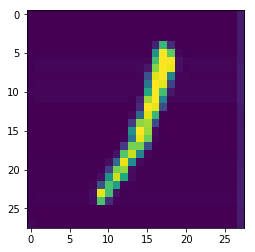

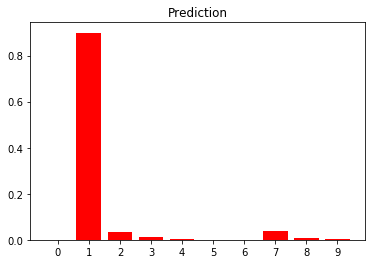

In [23]:
perform_prediction('digit01.jpg', predictions_logistic_regression) 


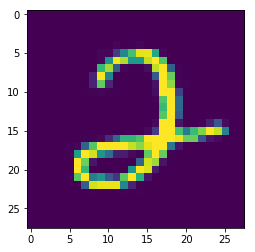

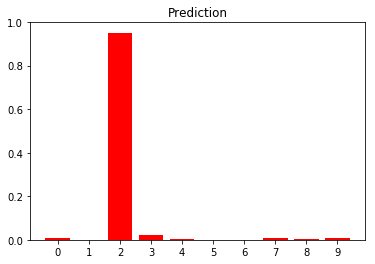

In [24]:
perform_prediction('digit02.jpg', predictions_logistic_regression) 


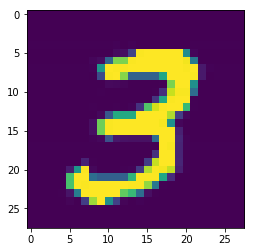

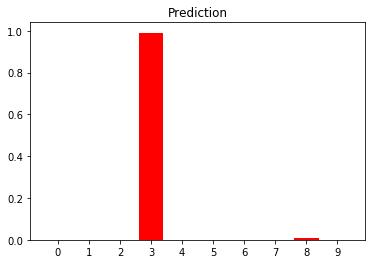

In [25]:
perform_prediction('digit03.jpg', predictions_logistic_regression) 


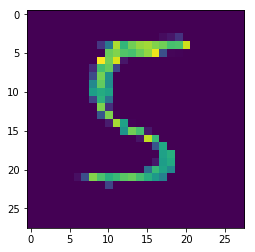

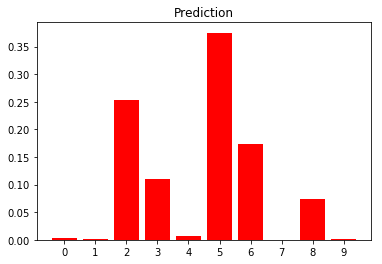

In [26]:
perform_prediction('05.png', predictions_logistic_regression) 

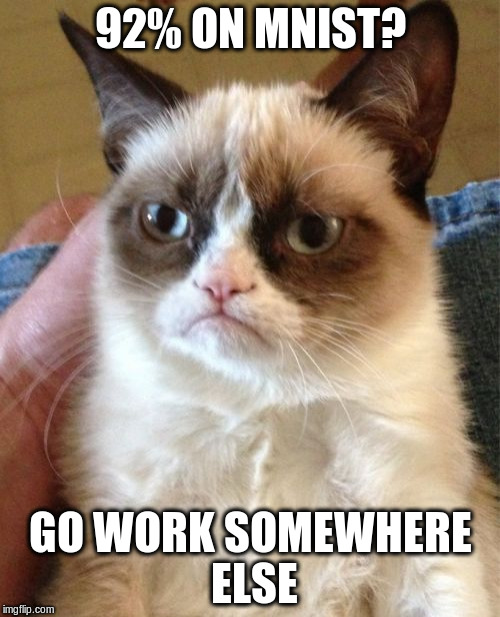

In [27]:
img = Image(filename='pictures/grumpy01.jpg')
img

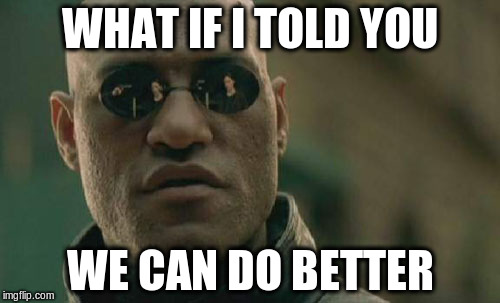

In [28]:
img = Image(filename='pictures/morhpeo01.jpeg')
img

### If instead using logistic regression we use a neuronal network, we will increase the performance substantially.

![title](pictures/nerualnet.png)

A neural network is composed of 1 or more hidden layer, in this example we will be adding a single hidden layer of 100 units

In [29]:
hidden_units = 100

weights = tf.Variable(tf.truncated_normal(shape=(columns, hidden_units), stddev=1/(hidden_units**0.5)))
biases = tf.Variable(tf.zeros(hidden_units))

weights_output = tf.Variable(tf.truncated_normal(shape=(hidden_units, labels), stddev=1/(labels**0.5)))
biases_output = tf.Variable(tf.zeros(labels))

X = tf.placeholder(tf.float32, shape=(None, columns), name="X")
y = tf.placeholder(tf.float32, shape=(None, labels), name="y")

hidden_output = tf.add(tf.matmul(X, weights), biases)
hidden_output = tf.nn.relu(hidden_output)

logits_nn1 = tf.add(tf.matmul(hidden_output, weights_output), biases_output)
predictions_nn1 = tf.nn.softmax(logits_nn1)

softmax_calc = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits_nn1)
cost = tf.reduce_mean(softmax_calc)

train_step = tf.train.AdamOptimizer().minimize(cost)

epochs_nn = 10

In [30]:

# Create session and initialize the variables
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
last_accuracy = 0
start_at = 0
for epoch_no in range(epochs_nn):
    for (X_chunk, y_chunk) in next_batch(X_train_normalized, y_train_one_hot, batch_size):
        train_step.run(feed_dict={X: X_chunk, y: y_chunk})
    
    correct_prediction = tf.equal(tf.argmax(y_train_one_hot,1), tf.argmax(logits_nn1, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy at epoch ", epoch_no, " is " , 
          accuracy.eval(feed_dict={X: X_train_normalized, y: y_train_one_hot}))
    
print("Final accuracy on test set")
correct_prediction = tf.equal(tf.argmax(y_test_one_hot,1), tf.argmax(logits_nn1,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={X: X_test_normalized, y: y_test_one_hot}))    

Accuracy at epoch  0  is  0.916191
Accuracy at epoch  1  is  0.941101
Accuracy at epoch  2  is  0.953899
Accuracy at epoch  3  is  0.962887
Accuracy at epoch  4  is  0.969345
Accuracy at epoch  5  is  0.973452
Accuracy at epoch  6  is  0.977262
Accuracy at epoch  7  is  0.98
Accuracy at epoch  8  is  0.982351
Accuracy at epoch  9  is  0.984048
Final accuracy on test set
0.96381


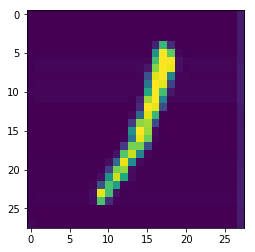

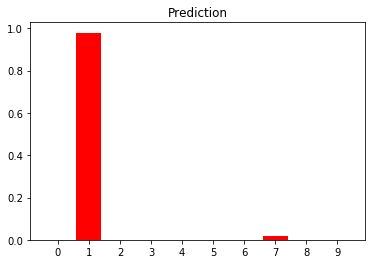

In [31]:
perform_prediction('digit01.jpg', predictions_nn1) 

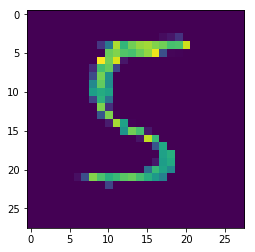

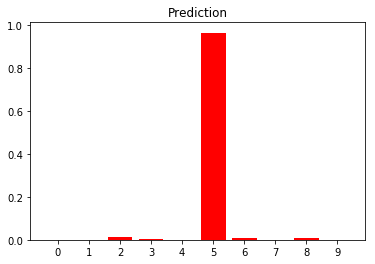

In [32]:
perform_prediction('05.png', predictions_nn1) 

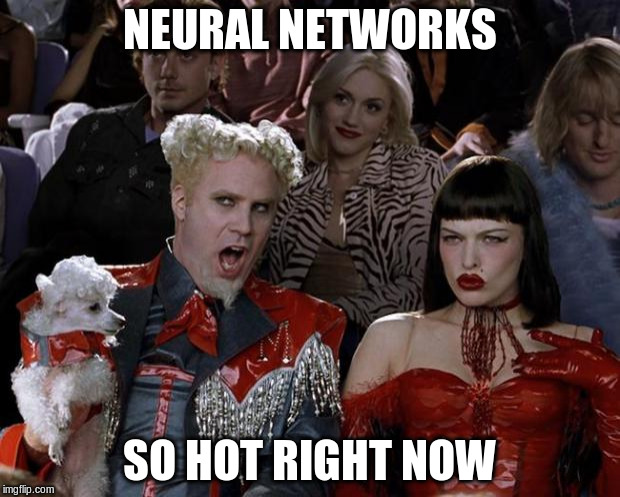

In [33]:
img = Image(filename='pictures/zoolander01.jpeg')
img

Using a neuronal network gives us a 96.6% accuracy, much better than the initial 92% achieve with logistic regression. 

Can we do better? Sure we can, but before that, lets rewrite the code with a higher level api provided by tensorflow, so we do not have to initialize weights or perform matrix multiplications ourselves.

In [ ]:
hidden_units = 100

epochs_nn = 10
X = tf.placeholder(tf.float32, shape=(None, columns), name="X")
y = tf.placeholder(tf.float32, shape=(None, labels), name="y")
hidden_output = tf.layers.dense(X, hidden_units, activation = tf.nn.relu)
logits_nn1 = tf.layers.dense(hidden_output, labels)  
predictions_nn1 = tf.nn.softmax(logits_nn1)
softmax_calc = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits_nn1)
cost = tf.reduce_mean(softmax_calc)

train_step = tf.train.AdamOptimizer().minimize(cost)



In [ ]:
# Create session and initialize the variables
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
last_accuracy = 0
start_at = 0
for epoch_no in range(epochs_nn):
    
    for (X_chunk, y_chunk) in next_batch(X_train_normalized, y_train_one_hot, batch_size):
        train_step.run(feed_dict={X: X_chunk, y: y_chunk})
    
    correct_prediction = tf.equal(tf.argmax(y_train_one_hot,1), tf.argmax(logits_nn1, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy at epoch", epoch_no, "is", accuracy.eval(feed_dict={X: X_train_normalized, y: y_train_one_hot}))
    
print("Final accuracy on test set")
correct_prediction = tf.equal(tf.argmax(y_test_one_hot,1), tf.argmax(logits_nn1,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={X: X_test_normalized, y: y_test_one_hot}))  

Accuracy at epoch 0 is 0.91369
Accuracy at epoch 1 is 0.936905
Accuracy at epoch 2 is 0.949732
Accuracy at epoch 3 is 0.957768
Accuracy at epoch 4 is 0.964881
Accuracy at epoch 5 is 0.970089
Accuracy at epoch 6 is 0.974048
Accuracy at epoch 7 is 0.977202


In [ ]:
perform_prediction('digit02.jpg', predictions_nn1) 
perform_prediction('05.png', predictions_nn1) 

As you can see, with the higher level api, the code gets much smaller, we can easily define our neuronal network layers just paying attention to the number of hidden units and the activation function, no need to initialize weights or perform matrix multiplications. 

Now it is the time to ...



In [ ]:
img = Image(filename='pictures/moreLayers01.jpeg')
img

In [ ]:
hidden_units_1 = 512
hidden_units_2 = 256

epochs = 10
X = tf.placeholder(tf.float32, shape=(None, columns), name="X")
y = tf.placeholder(tf.float32, shape=(None, labels), name="y")
hidden_output_1 = tf.layers.dense(X, hidden_units_1, activation = tf.nn.relu)
hidden_output_2 = tf.layers.dense(hidden_output_1, hidden_units_2, activation = tf.nn.relu)

logits_nn2 = tf.layers.dense(hidden_output_2, labels)  
predictions_nn2 = tf.nn.softmax(logits_nn2)
softmax_calc = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits_nn2)
cost = tf.reduce_mean(softmax_calc)

train_step = tf.train.AdamOptimizer().minimize(cost)

In [ ]:
# Create session and initialize the variables
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
last_accuracy = 0
start_at = 0
for epoch_no in range(epochs):
    for (X_chunk, y_chunk) in next_batch(X_train_normalized, y_train_one_hot, batch_size):
        train_step.run(feed_dict={X: X_chunk, y: y_chunk})

    correct_prediction = tf.equal(tf.argmax(y_train_one_hot,1), tf.argmax(logits_nn2, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy at epoch ", epoch_no, 
          "is", accuracy.eval(feed_dict={X: X_train_normalized, y: y_train_one_hot}))
    
print("Final accuracy on test set")
correct_prediction = tf.equal(tf.argmax(y_test_one_hot,1), tf.argmax(logits_nn2,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={X: X_test_normalized, y: y_test_one_hot}))  

In [ ]:
perform_prediction('digit02.jpg', predictions_nn2) 
perform_prediction('05.png', predictions_nn2) 

## We have got a bit better, 97.36% accuracy from the previous 96.5%.

Now we are in 97.78% which is a small improvement compared to the previous 97.36%, we could try to add more layers, but that is not going to solve things... we need to use other technique.

In [ ]:
img = Image(filename='pictures/aliens01.jpg')
img

In [ ]:
hidden_units_1 = 512
hidden_units_2 = 256
batch_size = 128
epochs = 5
X = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, labels), name="y")
    
   
# First convolution turns image into a 28x28x16
convolution_1 = tf.layers.conv2d(X,    
                                 16, # Output size
                                 (3,3), # Kernel/patch size
                                 strides=(1,1), 
                                 padding="SAME",
                                 activation=tf.nn.relu)



# Max pool to reduce image from 28x28x16 to 14x14x16   
convolution_1 = tf.layers.max_pooling2d(convolution_1, 
                                        3,  # Kernel/patch size 
                                        2,  # Strides, this will effectively shrink the output dimension, making 
                                            # it 28 / 2 = 14
                                        padding="SAME")



# Now, second convolution Goes from 14x14x16 to 7x7x32
convolution_2 = tf.layers.conv2d(convolution_1,    
                                 32, # Output size
                                 (3,3), # Kernel/patch size
                                 strides=(1,1), 
                                 padding="SAME",
                                 activation=tf.nn.relu)


convolution_2 = tf.layers.max_pooling2d(convolution_2, 
                                        3,  # Kernel/patch size 
                                        2,  # Strides, this will effectively shrink the output dimension, making 
                                            # it 14 / 2 = 7
                                        padding="SAME")

# So the output of the convolution is 7x7x32 = 1568, lets use that for a "normal" neural network



fully_connected_1 = tf.layers.dense(tf.reshape(convolution_2, (-1, 7*7*32)),
                                hidden_units_1, 
                                activation=tf.nn.relu)

fully_connected_2 = tf.layers.dense(fully_connected_1,
                                hidden_units_2, 
                                activation=tf.nn.relu)


logits_convnet = tf.layers.dense(fully_connected_2, labels)  
predictions_convnet = tf.nn.softmax(logits_convnet)
softmax_calc = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits_convnet)
cost = tf.reduce_mean(softmax_calc)

train_step = tf.train.AdamOptimizer().minimize(cost)

In [ ]:
# Create session and initialize the variables
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
last_accuracy = 0
start_at = 0
debug = True
for epoch_no in range(epochs):
    batch_no = 0
    for (X_chunk, y_chunk) in next_batch(X_train_normalized, y_train_one_hot, batch_size):
        
        X_chunk = X_chunk.reshape((-1, 28, 28, 1)) # Reshape our 784 vectors to 28x28x1 images
        if debug:
            debug = False
            print("Convolution 1", convolution_1.eval(feed_dict={X: X_chunk, y: y_chunk}).shape)
            print("Convolution 2", convolution_2.eval(feed_dict={X: X_chunk, y: y_chunk}).shape)
            print("Fully connected 1", fully_connected_1.eval(feed_dict={X: X_chunk, y: y_chunk}).shape)
            print("Fully connected 2", fully_connected_2.eval(feed_dict={X: X_chunk, y: y_chunk}).shape)
            
        train_step.run(feed_dict={X: X_chunk, y: y_chunk})
        if batch_no % 50 == 0:
            correct_prediction = tf.equal(tf.argmax(y_train_one_hot,1), tf.argmax(logits_convnet, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            print("Epoch ", epoch_no, 
                  " batch number ", batch_no, 
                  " \taccuracy ", accuracy.eval(feed_dict={X: X_train_normalized.reshape((-1, 28, 28, 1)), 
                                                         y: y_train_one_hot}))
            
        batch_no += 1       
print("Done!")        

In [ ]:
print("Final accuracy on test set")
correct_prediction = tf.equal(tf.argmax(y_test_one_hot,1), tf.argmax(logits_convnet,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={X: X_test_normalized.reshape((-1, 28, 28, 1)), y: y_test_one_hot}))  

In [ ]:
img = Image(filename='pictures/success01.jpeg')
img